In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from functools import reduce
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold, GroupKFold, ShuffleSplit
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

def wauc(true, scores):
    fpr, tpr, thresholds = roc_curve(true, scores, drop_intermediate=False)
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2.0, 1.0]
    auc_x = 0.0
    for idx in range(len(tpr_thresholds)-1):
        mask = tpr>=tpr_thresholds[idx]
        x = fpr[mask]
        y = tpr[mask]  
        mask = y>tpr_thresholds[idx+1]
        y[mask] = tpr_thresholds[idx+1]
        y = y-tpr_thresholds[idx]
        auc_x = auc_x + weights[idx]*np.trapz(y,x)
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    normalization = np.dot(areas, np.array(weights))    
    return auc_x/normalization

In [2]:
probabilities_zoo_holdout = pd.read_csv('probabilities_zoo_holdout_0718.csv', index_col=0)
FEATURES = ['NAME','QF', 
            'DCTR', 'JRM',
            #'SRNet_pc', 'SRNet_pjm', 'SRNet_pjuni', 'SRNet_puerd',
            'efn_b4_mish_pc',# 'efn_b4_mish_pjm','efn_b4_mish_pjuni','efn_b4_mish_puerd',
            'efn_b2_NR_mish_pc', 'efn_b2_NR_mish_pjm', 'efn_b2_NR_mish_pjuni', 'efn_b2_NR_mish_puerd',
            'MixNet_xl_mish_pc', #'MixNet_xl_mish_pjm','MixNet_xl_mish_pjuni','MixNet_xl_mish_puerd',
            'efn_b5_mish_pc', #'efn_b5_mish_pjm','efn_b5_mish_pjuni','efn_b5_mish_puerd',
            'efn_b6_NR_mish_pc',#'efn_b6_NR_mish_pjm','efn_b6_NR_mish_pjuni','efn_b6_NR_mish_puerd',
            'SRNet_noPC70_mckpt_pc',#'SRNet_noPC70_pjm','SRNet_noPC70_pjuni','SRNet_noPC70_puerd'
             ]

In [52]:
class DownsampledShuffleSplit:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
    def split(self, X, y, groups=None):
        for rx, tx in ShuffleSplit(self.n_splits, test_size=.25,).split(X,y):
            nix = np.where(y[tx]==0)[0]
            pix = np.where(y[tx]>0)[0]
            #pixu = pix[:nix.shape[0]]
            #np.random.seed(1994)
            pixu = np.random.choice(pix, size=nix.shape[0], replace=False)
            ix = np.append(nix, pixu)
            txm = tx[ix]
            yield rx, txm
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

probabilities_zoo_holdout = probabilities_zoo_holdout[probabilities_zoo_holdout.FOLD == 'TST']
labels = ~np.array(probabilities_zoo_holdout.CLASS == 'COVER') + 0
df_features = probabilities_zoo_holdout[FEATURES]
names = df_features.NAME
class gkf:
    def __init__(self, groups, n_splits=4):
        self.n_splits = n_splits
        self.groups=groups
    def split(self, X, y, groups=None):
        for rx, tx in GroupKFold(n_splits=self.n_splits).split(X,y,groups=self.groups):
            yield rx, tx
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

def scoring(estimator,X,y):
    scores = 1-estimator.predict_proba(X)[:,0]
    return wauc(y>0, scores)

bayes_cv_tuner = BayesSearchCV(
     estimator = CatBoostClassifier(
         #thread_count=10,
         objective = 'Logloss',
         cat_features = [0],
         iterations=150,
         scale_pos_weight=0.3333),
    
   # estimator = xgb.XGBClassifier(seed=42, tree_method='exact', booster='gblinear', num_boost_round=5000),
    
    search_spaces = {
        'learning_rate': (0.0001, 1.0, 'log-uniform'),
        'depth': (2, 13),
        #'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bylevel': (0.5, 1.0, 'uniform'),
        'l2_leaf_reg': (1.0, 50.0, 'uniform'),
        #'scale_pos_weight': (0.1, 5.0),
        ## XGB
        #'colsample_bylevel': (0.3, 1.0, 'uniform'),
        #'colsample_bytree': (0.3, 1.0, 'uniform'),
        #'colsample_bynode': (0.3, 1.0, 'uniform'),
        #'subsample': (0.3, 1.0, 'uniform'),
        #'learning_rate': (0.0001, 1.0, 'log-uniform'),
        #'eta': (0.01, 1.0, 'uniform'),
        #'max_depth': (2, 20),
        #'alpha': (0.0001, 1.0, 'log-uniform'),
        #'lambda':  (0.0001, 1.0, 'log-uniform'),
        #'n_estimators': (100, 300, 'uniform'),
        #'min_child_weight': (1, 10),
        #'scale_pos_weight': (0.1, 1.0, 'uniform'),
        
    },    
    scoring = scoring,
    cv = DownsampledShuffleSplit(
        n_splits=10,
    ),
    n_jobs = 10,
    n_iter = 60,   
    verbose = 0,
    refit = True,
    random_state = None
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = bayes_cv_tuner.cv_results_  
    # Get current parameters and the best parameters    
    best_params = bayes_cv_tuner.best_params_
    print('Model #{}\nBest WAUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
df_features['QF'] = df_features['QF'].astype('int').astype('str')

if False:
    oh = OneHotEncoder()
    oh.fit(df_features['QF'].values.reshape(-1, 1))
    qf_oh = oh.transform(df_features['QF'].values.reshape(-1, 1)).toarray()
    X = df_features.values[:,2:]
    X = np.c_[qf_oh,X]
else: 
    X = df_features.values[:,1:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
result = bayes_cv_tuner.fit(X, 
                            labels, 
                            callback=status_print)

Model #22
Best WAUC: 0.9374
Best params: OrderedDict([('colsample_bylevel', 0.8874215816471416), ('depth', 6), ('l2_leaf_reg', 1.1479870990738419), ('learning_rate', 0.004673743210819987)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDi

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDict([('colsample_bylevel', 0.9486733496674717), ('depth', 6), ('l2_leaf_reg', 40.990403393063545), ('learning_rate', 0.01786771119017783)])

Model #22
Best WAUC: 0.9409
Best params: OrderedDi

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #22
Best WAUC: 0.9413
Best params: OrderedDict([('colsample_bylevel', 0.5116707529466404), ('depth', 3), ('l2_leaf_reg', 49.91897773793486), ('learning_rate', 0.00010010626734225567)])



/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #22
Best WAUC: 0.9413
Best params: OrderedDict([('colsample_bylevel', 0.5116707529466404), ('depth', 3), ('l2_leaf_reg', 49.91897773793486), ('learning_rate', 0.00010010626734225567)])

Model #22
Best WAUC: 0.9413
Best params: OrderedDict([('colsample_bylevel', 0.5116707529466404), ('depth', 3), ('l2_leaf_reg', 49.91897773793486), ('learning_rate', 0.00010010626734225567)])

Model #22
Best WAUC: 0.9413
Best params: OrderedDict([('colsample_bylevel', 0.5116707529466404), ('depth', 3), ('l2_leaf_reg', 49.91897773793486), ('learning_rate', 0.00010010626734225567)])

Model #22
Best WAUC: 0.9413
Best params: OrderedDict([('colsample_bylevel', 0.5116707529466404), ('depth', 3), ('l2_leaf_reg', 49.91897773793486), ('learning_rate', 0.00010010626734225567)])

Model #22
Best WAUC: 0.9413
Best params: OrderedDict([('colsample_bylevel', 0.5116707529466404), ('depth', 3), ('l2_leaf_reg', 49.91897773793486), ('learning_rate', 0.00010010626734225567)])

Model #22
Best WAUC: 0.9413
Best params:

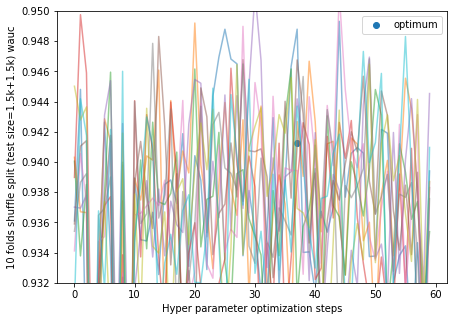

In [40]:
means = np.array(result.cv_results_['mean_test_score'])
means_cv = [np.array(result.cv_results_['split'+str(k)+'_test_score']) for k in range(10)]

stds = np.array(result.cv_results_['std_test_score'])
ranks = np.array(result.cv_results_['rank_test_score'])
plt.figure(figsize=(7,5))

for k in range(10):
    plt.plot(means_cv[k][:], alpha=0.5)
    
#plt.fill_between(range(len(means)),means-stds,means+stds, alpha=.2, label='+/- std')
plt.scatter(np.where(ranks==1)[0],means[ranks==1], label='optimum')
plt.ylabel('10 folds shuffle split (test size=1.5k+1.5k) wauc')
plt.xlabel('Hyper parameter optimization steps')
plt.ylim([0.932,0.95])
plt.legend()
plt.show()

In [54]:
probabilities_zoo_lb = pd.read_csv('probabilities_zoo_lb_0718.csv', index_col=0)

In [ ]:
df_features = probabilities_zoo_lb[FEATURES]
df_features['QF'] = df_features['QF'].astype('int').astype('str')

if False:
    qf_oh = oh.transform(df_features['QF'].values.reshape(-1, 1)).toarray()
    X_lb = df_features.values[:,2:]
    X_lb = np.c_[qf_oh,X_lb]
else:
    X_lb = df_features.values[:,1:]

estimator = result.best_estimator_                                     
score_lb = estimator.predict_proba(X_lb)[:,1]

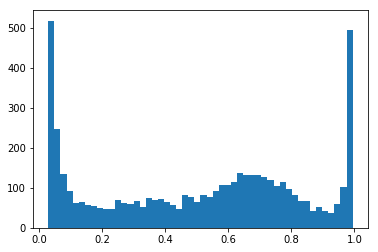

4127    0.989025
Name: Label, dtype: float64
1799    0.979589
Name: Label, dtype: float64
1715    0.974008
Name: Label, dtype: float64
2866    0.97226
Name: Label, dtype: float64
3244    0.837765
Name: Label, dtype: float64
1043    0.983609
Name: Label, dtype: float64
4454    0.98464
Name: Label, dtype: float64
373    0.973416
Name: Label, dtype: float64
4791    0.955109
Name: Label, dtype: float64
1770    0.987538
Name: Label, dtype: float64


In [191]:
plt.hist(score_lb,bins=50)
plt.show()
sub = pd.DataFrame({"Id":df_features.NAME, "Label":score_lb})
oor = ['2395.jpg' ,'0412.jpg', '0146.jpg', '3578.jpg', '4747.jpg', '3128.jpg', '3395.jpg', '1208.jpg', '4415.jpg', '0327.jpg']
for im_name in oor:
    print(sub.loc[sub.Id==im_name, 'Label'])
    sub.loc[sub.Id==im_name, 'Label'] = 1.01
#sub.to_csv('submission_v28_all_xgb.csv', index=False)